# Processamento de Linguagem Natural aplicada à Gestão Pública

Aula 4 (08/06): Similaridade Textual

Cálculo de similaridade entre documentos e entre palavras. Análise de Semântica Latente. Outras formas de representação númérica de palavras.


Na última aula vimos como obter a matriz TF-IDF a partir de um conjunto de textos. Vamos recarregar o conjunto de textos já processado.

In [1]:
# Download dos dados
%%capture
!pip install spacy==3.3.0
!git clone https://github.com/samuelbarbosaa/oficina_nlp.git

In [2]:
# Download e extração do modelo spaCy em Português
import gdown
import tarfile

url = 'https://drive.google.com/uc?id=1-zEjxcpyd3OwBI1Uve90MMcIkjRPH7FR'
output = 'pt_core_news_lg-3.3.0.tar.gz'
gdown.download(url, output, quiet=False)

file = tarfile.open('pt_core_news_lg-3.3.0.tar.gz')
file.extractall('./')
file.close()

Downloading...
From: https://drive.google.com/uc?id=1-zEjxcpyd3OwBI1Uve90MMcIkjRPH7FR
To: /content/pt_core_news_lg-3.3.0.tar.gz
100%|██████████| 568M/568M [00:03<00:00, 158MB/s]


In [3]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
# Carrega textos já processados
with open('/content/oficina_nlp/data/textos_padronizados.pkl', 'rb') as fp:
  textos_proposicoes = pickle.load(fp)

textos_proposicoes

texto_padr  \
siglaTipoProjeto numero ano                                                       
PL               502    1999  projeto lei autorizar executivo criar concessã...   
                 2126   2002  projeto lei alterar dispositivo lei dezembro c...   
                 2127   2002  projeto lei alterar redação art lei dezembro d...   
                 120    2003  projeto lei projeto lei instituir medalha méri...   
                 1519   2004  projeto lei dispor gratuidade tranporte coleti...   
...                                                                         ...   
                 3614   2022  projeto lei autorizar executivo doar município...   
PEC              81     2022  proposta emenda constituição acrescentar art i...   
PL               3622   2022  projeto lei declarar utilidade público institu...   
                 3624   2022  projeto lei denominação viaduto localizar alça...   
                 3625   2022  projeto lei autorizar executivo doar município...   

                                                                          texto  
siglaTipoProjeto numero ano                                                      
PL               502    1999  PROJETO DE LEI Nº 502/99 Autoriza o Poder Exec...  
                 2126   2002  PROJETO DE LEI Nº 2.126/2002 Altera dispositiv...  
                 2127   2002  PROJETO DE LEI Nº 2.127/2002 Altera a redação ...  
                 120    2003  PROJETO DE LEI Nº 120/2003 (EX-PROJETO DE LEI ...  
                 1519   2004  PROJETO DE LEI Nº 1.519/2004 Dispõe sobre a gr...  
...                                                                         ...  
                 3614   2022  # Projeto de Lei nº 3.614/2022\n\nAutoriza o P...  
PEC              81     2022  # Proposta de Emenda à Constituição nº 81/2022...  
PL               3622   2022  # Projeto de Lei nº 3.622/2022\n\nDeclara de u...  
                 3624   2022  # Projeto de Lei nº 3.624/2022\n\nDá denominaç...  
                 3625   2022  # Projeto de Lei nº 3.625/2022\n\nAutoriza o P...  

[4534 rows x 2 columns]

Execute o código a seguir para aplicar o método de vetorização TF-IDF.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

metodo = TfidfVectorizer()
modelo = metodo.fit(textos_proposicoes["texto_padr"])
TF_IDF = modelo.transform(textos_proposicoes["texto_padr"])
TF_IDF

<4534x23841 sparse matrix of type '<class 'numpy.float64'>'
	with 729992 stored elements in Compressed Sparse Row format>

In [7]:
TF_IDF[0:10, 0:10].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Similaridade entre documentos (ou termos)

De posse da matriz DTM ou da TF-IDF podemos agora aplicar métodos computacionais, de álgebra linear e estatísticos aos documentos (vetores-linha) termos (vetores-coluna) ou à toda a matriz.

Uma das possibilidades da álgebra linear é o **cálculo de distância entre vetores**. Aplicado às linhas e colunas da DTM ou TF-IDF, teremos uma medida de similaridade entre documentos ou entre termos. 

Antes de realizar estes cálculos vamos revisar, brevemente, notação e operações básicas com vetores.

## Vetores

Um vetor é, *informalmente*, uma lista (ordenada) de números.

> Definição formal: elemento de um espaço vetorial.

$\mathbf{x} \in \mathbb{R}^n = [x_1, ..., x_n]$

<br>
Vetor coluna:

\begin{equation*}
\mathbf{x} = 
\begin{bmatrix}
x_1 \\
... \\
x_n 
\end{bmatrix}
\end{equation*}

Vetor linha:

\begin{equation*}
\mathbf{x} = 
\begin{bmatrix}
x_1 &
... &
x_n 
\end{bmatrix}
\end{equation*}

Operações/definições básicas:

Adição: 
$$\mathbf{u} + \mathbf{v} = [u_1 + v_1, ..., u_n + v_n]$$

Transposição:

<br>
Vetor coluna:

\begin{equation*}
\mathbf{x} = 
\begin{bmatrix}
x_1 \\
... \\
x_n 
\end{bmatrix} \iff \mathbf{x}^\top = \begin{bmatrix}
x_1 &
... &
x_n 
\end{bmatrix}
\end{equation*}

Produto escalar: 
$$\mathbf{u} ^\top \mathbf{v} = u_1 v_1 + ... + u_n v_n = \mathbf{u} \cdot \mathbf{v}$$

Norma (euclidiada) (tamanho):
$$||\mathbf{u}|| = \sqrt{\mathbf{u}^\top \mathbf{u}} = \sqrt{ u_1^2 + ... + u_n^2 }$$

Segue desta última definição que $||\mathbf{u}||^2 = \mathbf{u}^\top \mathbf{u}$.


## Distância entre vetores

### Distância Euclidiana

Uma das definições mais usuais de distância entre vetores é a distância euclidiana:

![Distância Euclidiana](https://www.tutorialexample.com/wp-content/uploads/2020/05/Euclidean-distance-in-tensorflow.png)

Vamos realizar o cálculo da distância euclidiana entre os documentos e analisar os resultados.

In [8]:
from sklearn.metrics.pairwise import euclidean_distances

E = euclidean_distances(TF_IDF)
E.shape

(4534, 4534)

A matriz `E` é a matriz de distâncias entre as linhas (documentos) da matriz TF-IDF. Observe que essa matriz tem 4.534 linhas e 4.534 colunas. Cada entrada $E_{ij}$ dessa matriz representa a distância da linha $i$ para a linha $j$ na matriz TF-IDF.  

In [ ]:
E[1:5, 1:5]

array([[0.        , 1.2993662 , 1.3783544 , 1.35200118],
       [1.2993662 , 0.        , 1.37976143, 1.28020757],
       [1.3783544 , 1.37976143, 0.        , 1.37361134],
       [1.35200118, 1.28020757, 1.37361134, 0.        ]])

A matriz de distâncias é simétrica ($E = E^\top)$, isto é, a distância entre $i$ e $j$ é a igual à distância entre $j$ e $i$. Não por acaso os elementos da diagonal são iguais a zero (a distância de documento para ele mesmo).

Além disso, o gráfico a seguir evidencia que a maioria dos documentos tem distância calculada entre 1.2 e 1.4, reflexo da esparsidade da matriz TF-IDF (maioria das entradas iguais a zero).

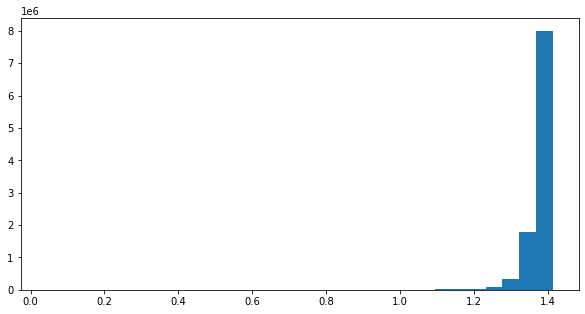

In [9]:
upper_E = np.triu(E).flatten()
upper_E = upper_E[upper_E>0]
plt.hist(upper_E, bins=30)
plt.show()

Os dois projetos de Lei a seguir tratam do mesmo assunto. Vamos ver o texto e verificar a distância calculada.

- [PL 5135 2018](https://www.almg.gov.br/atividade_parlamentar/tramitacao_projetos/texto.html?a=2018&n=5135&t=PL)
- [PL 12 2019](https://www.almg.gov.br/atividade_parlamentar/tramitacao_projetos/texto.html?a=2019&n=12&t=PL)

In [10]:
textos_proposicoes.iloc[[1687, 1913]]

texto_padr  \
siglaTipoProjeto numero ano                                                       
PL               5135   2018  projeto lei dispor obrigatoriedade edifício pú...   
                 12     2019  projeto lei dispor informação âmbito direito a...   

                                                                          texto  
siglaTipoProjeto numero ano                                                      
PL               5135   2018  # Projeto de Lei nº 5.135/2018\n\nDispõe sobre...  
                 12     2019  # Projeto de Lei nº 12/2019  Dispõe sobre a in...

In [11]:
d = E[1687, 1913]
print(f"Distância entre o texto das proposições: {d:.2f}")

Distância entre o texto das proposições: 0.78


A **distância** entre esses documentos é de fato menor do que a maioria das distâncias calculadas.

In [12]:
pct_menor = np.mean(upper_E < E[1687, 1913])
pct_maior = np.mean(upper_E > E[1687, 1913])
print(f"Percentual de documentos com distância menor do que {d:.2f}: {pct_menor:.2f}")
print(f"Percentual de documentos com distância maior do que {d:.2f}: {pct_maior:.2f}")

Percentual de documentos com distância menor do que 0.78: 0.00
Percentual de documentos com distância maior do que 0.78: 1.00


In [17]:
np.mean(upper_E < 1.2)

0.004543070421192043

Vamos escrever uma função que retorna os $n$ documentos menos distantes do selecionado.

In [18]:
def n_documentos_mais_proximos(indice_documento, n, textos=textos_proposicoes):
  distancias_documento = E[indice_documento, :]                            # Extrai a linha referente ao documento indicado
  docs_proximos = np.argpartition(distancias_documento, n)[:n]             # Identifica o índice dos n documentos mais próximos
  print(f"Documento indicado: {textos.iloc[indice_documento].name}.")
  print("Documentos mais próximos:")
  return docs_proximos

In [19]:
textos_proposicoes.iloc[n_documentos_mais_proximos(1687, 5)]

Documento indicado: ('PL', 5135, 2018).
Documentos mais próximos:


texto_padr  \
siglaTipoProjeto numero ano                                                       
PL               5135   2018  projeto lei dispor obrigatoriedade edifício pú...   
                 2011   2015  projeto lei projeto lei estabelecer política e...   
                 5136   2018  projeto lei dispor distribuição cópia lei bras...   
                 12     2019  projeto lei dispor informação âmbito direito a...   
                 352    2019  projeto lei criar fundo estadual direito pesso...   

                                                                          texto  
siglaTipoProjeto numero ano                                                      
PL               5135   2018  # Projeto de Lei nº 5.135/2018\n\nDispõe sobre...  
                 2011   2015  # projeto de lei nº 2.011/2015\n\n### (Ex-Proj...  
                 5136   2018  # Projeto de Lei nº 5.136/2018\n\nDispõe sobre...  
                 12     2019  # Projeto de Lei nº 12/2019  Dispõe sobre a in...  
                 352    2019  # PROJETO DE LEI Nº 352/2019\n\nCria o Fundo E...

- [PL 2011 2015](https://www.almg.gov.br/atividade_parlamentar/tramitacao_projetos/texto.html?a=2015&n=2011&t=PL)
- [PL 352 2019](https://www.almg.gov.br/atividade_parlamentar/tramitacao_projetos/texto.html?a=2019&n=352&t=PL)

Outro exemplo:

In [20]:
print(textos_proposicoes.loc[("PL", 1451, 2020), "texto"][0:115])

# Projeto de lei nº 1.451/2020

Reajusta os valores das tabelas de vencimento básico das categorias que
menciona.




In [21]:
idx_exemplo = textos_proposicoes.index.get_loc(("PL", 1451, 2020))
textos_proposicoes.iloc[n_documentos_mais_proximos(idx_exemplo, 5)]

Documento indicado: ('PL', 1451, 2020).
Documentos mais próximos:


texto_padr  \
siglaTipoProjeto numero ano                                                       
PL               3417   2021  projeto lei dispor reajuste vencimento provent...   
                 3568   2022  projeto lei dispor revisão subsídio vencimento...   
                 1451   2020  projeto lei reajustar valor tabelo vencimento ...   
                 1448   2020  projeto lei dispor reajuste vencimento provent...   
                 1449   2020  projeto lei fixo percentual revisão anual venc...   

                                                                          texto  
siglaTipoProjeto numero ano                                                      
PL               3417   2021    1. # PROJETO DE LEI Nº 3.417/2021\n\nDispõe ...  
                 3568   2022  # Projeto de lei nº 3.568/2022\n\nDispõe sobre...  
                 1451   2020  # Projeto de lei nº 1.451/2020\n\nReajusta os ...  
                 1448   2020    1. # PROJETO DE LEI Nº 1.448/2020\n\nDispõe ...  
                 1449   2020  # **PROJETO DE LEI n º 1.449/2020**\n\nFixa o ...

### Similaridade Cosseno

Uma segunda métrica muito utilizada em NLP é a similaridade cosseno:

<img src="https://drive.google.com/uc?export=view&id=1Yer_rr1jH8sY9FTDrLK37qUS6DydGR-V" />


<img src="https://drive.google.com/uc?export=view&id=17OYOuzIBws-qEodsc9qBKd8pxLCa2eG_" />

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
SC = cosine_similarity(TF_IDF)

In [24]:
SC.shape

(4534, 4534)

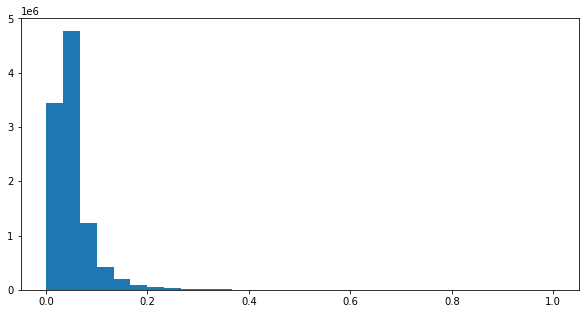

In [25]:
upper_SC = np.triu(SC).flatten()
upper_SC = upper_SC[upper_SC>0]
plt.hist(upper_SC, bins=30)
plt.show()

A primeira propriedade interessante da similaridade cosseno é que os valores calculados estão entre zero e um. Como se trata de uma medida de similaridade, em oposição a distância, valores maiores representam documentos mais próximos.

In [27]:
s = SC[1687, 1913]
print(f"Similaridade entre os textos das proposições: {s:.2f}")

Similaridade entre os textos das proposições: 0.70


O pacote spaCy permite um cálculo de similaridade (metodologicamente distinto do que produzimos):

In [28]:
import spacy

nlp = spacy.load("/content/pt_core_news_lg-3.3.0/pt_core_news_lg/pt_core_news_lg-3.3.0")

In [29]:
doc1 = nlp(textos_proposicoes.iloc[1687]["texto_padr"])
doc2 = nlp(textos_proposicoes.iloc[1913]["texto_padr"])

doc1.similarity(doc2)

0.9854514542739218

Vamos considerar, porém, outros dois documentos sem muita relação:

In [30]:
print(textos_proposicoes.iloc[3011]["texto"][slice(0,195)])

# PROJETO DE LEI Nº 1.444/2020

Fixa o percentual, relativo aos anos de 2018 e 2019, para revisão anual dos
vencimentos e proventos dos servidores do Ministério Público do Estado de
Minas Gerais.


In [31]:
print(textos_proposicoes.iloc[3384]["texto"][slice(0,168)])

#  PROJETO DE RESOLUÇÃO Nº 83/2020

Reconhece o estado de calamidade pública no Município de Ouro Fino em
decorrência da pandemia de Covid-19, causada pelo coronavírus.


Nossos cálculos de distância e similaridade com a matriz TF-IDF retornam alta distância e baixa similaridade:

In [32]:
E[3011, 3384]

1.3689558378388293

In [33]:
SC[3011, 3384]

0.06297995702349382

A aplicação do spaCy, porém, retorna ainda similaridade alta:

In [34]:
doc1 = nlp(textos_proposicoes.iloc[3011]["texto_padr"])
doc2 = nlp(textos_proposicoes.iloc[3384]["texto_padr"])

doc1.similarity(doc2)

0.9117510142750419

Isto se deve ao contexto do conjunto de textos (*corpus*) que utilizamos. O método do spaCy utiliza vetores inferidos com conjuntos de textos maiores e mais diversos.